In [2]:
import gizeh as gz
import json
import numpy as np
import pandas as pd
import glob
from more_itertools.recipes import grouper, pairwise
from PIL import Image
from sklearn.preprocessing import StandardScaler

print("Jupyter online")

Jupyter online


In [3]:
def open_json(jsonfile):
    jsonopen = open(jsonfile)
    jfile = json.load(jsonopen)
    jsonopen.close()
    x = pd.DataFrame(jfile)
    return x

def framenames(path, fps):
    frames = np.arange(0, 900*fps+1, 24).tolist()
    startname = 'frame'
    endname = '_keypoints.json'
    frames = frames[1:]
    framelist = []
    for i in frames:
        framelist.append(path+startname+str(i)+endname)
    return(framelist)

def data_loader(framelist):
    pose1= []
    pose2= []
    count1 = 0
    count2 = 0
    count3 = 0
    count4 = 0
    count5 = 0
    for jsonfile in framelist:
        data = open_json(jsonfile)
        if len(data.index) == 2:
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count1 += 1
        if len(data.index) == 3:
            s1 = data.iloc[0,:]
            s2 = data.iloc[2,:]
            count2 += 1
        if len(data.index) == 1:
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count3 += 1
        if len(data.index) == 4:        #NEEDS WORK, KN5 frame 216 has 4 skeletons in it
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count4 += 1
        if len(data.index) == 5:
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count5 += 1

        sig1 = s1["people"]
        sig2 = s2["people"]

        signer1poses = pd.DataFrame.from_dict(sig1, orient='index')
        signer2poses = pd.DataFrame.from_dict(sig2, orient='index')

        signer1 = signer1poses.iloc[1:5,:]
        signer2 = signer2poses.iloc[1:5,:]

        signer1 = signer1.drop(["face_keypoints_2d"])
        signer2 = signer2.drop(["face_keypoints_2d"])
        
        pose1.append(signer1)
        pose2.append(signer2)
    poses = pose1 + pose2
    print('There are '+str(count3)+' frames with 1 person in them')
    print('There are '+str(count1)+' frames with 2 persons in them')
    print('There are '+str(count2)+' frames with 3 persons in them')
    print('There are '+str(count4)+' frames with 4 persons in them')
    print('There are '+str(count5)+' frames with 5 persons in them')
    return poses

def scale(lst):                                 #Look into standardscaler from sklearn
    newdata = []
    for i,d in enumerate(lst):
        if d.any() > 0:
           newdata.append(d/500)
        else:
            newdata.append(d)
    return newdata

#def scale(lst):
#    scaler = StandardScaler()
#    newdata = scaler.fit_transform(lst)
#    return newdata

def normalizer(lst,nmbr):
    fin = []
    norm = (nmbr*1.8)
    #assuming person 2 always sits on the right in the frame which gives him/her different y coordinates but similar x coordinates.
    z = np.array([norm,0])
    #normalize the y coordinate appropriately for person 1 so relative distances stay the same. 
    for i,d in enumerate(lst):
        if d.any() > 0:
            d = d-z
            fin.append(d)
        else:
            fin.append(d) 
    return fin

def pose_processor(poses):                                                      #Finish pose processor
    poses = poses
    lengthp = len(poses)
    middle = lengthp/2
    p1 = poses[:int(middle)]
    p2 = poses[int(middle):]

    #Create confidenceintervals index
    confidenceintervals = np.arange(-1, 75, 3).tolist()
    confidenceintervals = confidenceintervals[1:]
    #print(confidenceintervals)

    #Create x and y coordinates index
    coordinates = np.arange(0, 75, 1).tolist()
    cs1 = set(confidenceintervals)
    coorindex = [x for x in coordinates if x not in cs1]
    #print(coorindex)

    person1 = []
    for framepose in p1:
        signer1 = pd.DataFrame(framepose) 
        skel1 = signer1.iloc[0,:]
        #Get confidence intervals for signer 1 and 2 per keypoint
        ci1 = [skel1[i] for i in confidenceintervals]
        #Get x and y coordinates for signer 1 and 2 per keypoint
        skelcoor1 = [skel1[i] for i in coorindex]
        sk1 = np.array_split(skelcoor1, 25)
        #Normalize on neck Y coordinate as neck position
        neck2 = sk1[1]
        newdata1 = scale(normalizer(sk1, neck2[0]))
        person1.append(newdata1)
        
    person2 = []
    for framepose in p2:
        signer2 = pd.DataFrame(framepose) 
        skel2 = signer2.iloc[0,:]
        #Get confidence intervals for signer 1 and 2 per keypoint
        ci2 = [skel2[i] for i in confidenceintervals]
        #Get x and y coordinates for signer 1 and 2 per keypoint
        skelcoor2 = [skel2[i] for i in coorindex]
        sk2 = np.array_split(skelcoor2, 25)

        newdata2 = scale(sk2)
        person2.append(newdata2)
    #return sk1, sk2
    signers = person1 + person2
    return signers

def hand_processor(poses):                                          #Under  construction
    poses = poses
    lengthp = len(poses)
    middle = lengthp/2
    p1 = poses[:int(middle)]
    p2 = poses[int(middle):]

    #Create confidenceintervals index
    confidenceintervalh = np.arange(-1, 63, 3).tolist()
    confidenceintervalh = confidenceintervalh[1:]
    #print(confidenceintervalh)

    #Create x and y coordinates index
    coordinateh = np.arange(0, 63, 1).tolist()
    csi2 = set(confidenceintervalh)
    coorindexhand = [x for x in coordinateh if x not in csi2]
    #print(coorindexhand)

    person1 = []                                        #CHANGE VARIABLE NAME
    for framepose in p1:
        signer1 = pd.DataFrame(framepose) 
        hand1_L = signer1.iloc[1,:]
        hand1_R = signer1.iloc[2,:]
        hand1_L = hand1_L.dropna(axis='rows')
        hand1_R = hand1_R.dropna(axis='rows')
        #Get confidence intervals for signer 1 and 2 per keypoint per hand
        H1L = [hand1_L[i] for i in confidenceintervalh]
        H1R = [hand1_R[i] for i in confidenceintervalh]
        #Get x and y coordinates for signer 1 and 2 per keypoint
        hand1R = [hand1_L[i] for i in coorindexhand]
        hand1L = [hand1_R[i] for i in coorindexhand]
        #print(len(hand1L))
        #Split the list into x, y coordinate arrays
        handR11 = np.array_split(hand1R, 21)
        handL11 = np.array_split(hand1L, 21)
        #Normalize on 240, from Songha Ban's code.
        handR1 = scale(normalizer(handR11, 240))
        handL1 = scale(normalizer(handL11, 240))
        #Join them into 1 list with numpy arrays
        hand1 = [handR1, handL1]
        person1.append(hand1)

    person2 = []                                        #CHANGE VARIABLE NAME
    for framepose in p2:
        signer2 = pd.DataFrame(framepose) 
        hand2_L = signer2.iloc[1,:]
        hand2_R = signer2.iloc[2,:]
        hand2_L = hand2_L.dropna(axis='rows')
        hand2_R = hand2_R.dropna(axis='rows')
        #Get confidence intervals for signer 1 and 2 per keypoint per hand
        H2L = [hand2_R[i] for i in confidenceintervalh]
        H2R = [hand2_R[i] for i in confidenceintervalh]
        #Get x and y coordinates for signer 1 and 2 per keypoint
        hand2R = [hand2_L[i] for i in coorindexhand]
        hand2L = [hand2_R[i] for i in coorindexhand]
        #print(len(hand1L))
        #Split the list into x, y coordinate arrays
        handR22 = np.array_split(hand2R, 21)
        handL22 = np.array_split(hand2L, 21)
        handR2 = scale(handR22)
        handL2 = scale(handL22)
        #Join them into 1 list with numpy arrays
        hand2 = [handR2, handL2]
        person2.append(hand2)
    return person1, person2

def data_shaper(signers, hands):
    poses = signers
    lengthp = len(poses)
    middle = lengthp/2
    p1 = poses[:int(middle)]
    p2 = poses[int(middle):]
    tot = []
    for i in range(0,900):
        newdata1 = []
        for value in p1[i]:
            for coordinate in value:
                x = round(coordinate, 8)
                newdata1.append(x)

        newdata2 = []
        for value in p2[i]:
            for coordinate in value:
                x = round(coordinate, 8)
                newdata2.append(x)
        shaped = np.array(newdata1 + newdata2)
        tot.append(shaped)
    end = np.array(tot)
    end = end.reshape(1,900,100)
    return end

def label_loader(labelspath):
    data = pd.read_csv(labelspath)
    data2 = data.iloc[:,3]
    labels = data2
    labels = np.array(labels)
    return labels

def finish_processing(path,fps,labelspath):
    framelist = framenames(path, fps)
    poses = data_loader(framelist)
    processedsk = pose_processor(poses)
    #processedhands = hand_processor(poses)
    features = processedsk
    #features = data_shaper(processedsk,processedhands)
    labels = label_loader(labelspath)
    return np.array(features)


In [4]:
path = 'D:\Videos thesis\KN5Jan7_poses\KN5Jan7_poses\\'
fps = 24
labelspath = 'D:\Videos thesis\KN5jan7_annotated.csv'
labels = label_loader(labelspath)
z = finish_processing(path, fps, labelspath)
print(z.shape)
print(labels.shape)

There are 0 frames with 1 person in them
There are 809 frames with 2 persons in them
There are 90 frames with 3 persons in them
There are 1 frames with 4 persons in them
There are 0 frames with 5 persons in them
(1800, 25, 2)
(900,)


In [5]:
np.random.seed(0)
import tensorflow as tf
import torch

from pytorch_tabnet.tab_model import TabNetClassifier
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
poses = z
lengthp = len(poses)
middle = lengthp/2
p1 = poses[:int(middle)]
p2 = poses[int(middle):]

#explain what this does
tf.compat.v1.disable_eager_execution()

tot1 = []
tot2 = []
for i in range(0,900):
        newdata1 = []
        for value in p1[i]:
            for coordinate in value:
                x = round(coordinate, 8)
                newdata1.append(x)
        newdata2 = []
        for value in p2[i]:
            for coordinate in value:
                x = round(coordinate, 8)
                newdata2.append(x)
        tot1.append(newdata1)
        tot2.append(newdata2)
        #for value in labels[i]:
        #        print(value)
final1 = np.array(tot1)
final2 = np.array(tot2)

dataset = np.hstack((final1, final2))
labels = pd.DataFrame(labels)
dataset = pd.DataFrame(dataset)
#df = pd.DataFrame(dataset)
#labels = pd.DataFrame(y)
#mx = df.to_numpy().min()
#print(mx)

X = pd.DataFrame(dataset)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 1) # 0.26666 x 0.75 = 0.2

X_train = np.array(X_train)
#X_train = X_train.reshape(1,len(X_train),100)
print(X_train.shape)
X_test = np.array(X_test)
#X_test = X_test.reshape(1,len(X_test),100)
print(X_test.shape)

X_val = np.array(X_val)
print(X_val.shape)


y_train = np.array(y_train)
y_train = np.squeeze(y_train)
#y_train = y_train.reshape(1,len(y_train))
print(y_train.shape)
y_test = np.array(y_test)
y_test = np.squeeze(y_test)
#y_test = y_test.reshape(1,len(y_test))
print(y_test.shape)

y_val = np.array(y_val)
y_val = np.squeeze(y_val)
print(y_val.shape)



(404, 100)
(297, 100)
(199, 100)
(404,)
(297,)
(199,)


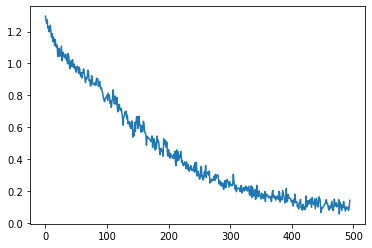

In [9]:
plt.plot(clf.history['loss'][5:])

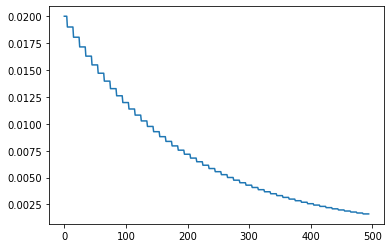

In [10]:
plt.plot([x for x in clf.history['lr']][5:])

In [14]:
X = pd.DataFrame(dataset)
print(labels)

     0
0    0
1    0
2    0
3    0
4    0
..  ..
895  1
896  1
897  3
898  3
899  3

[900 rows x 1 columns]


In [10]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
from itertools import cycle

def show_roc_plot(y_true, y_pred, i):
    fold = str(i)
    n_classes = 4
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw = 2
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,10))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    #plt.savefig('ROC'+fold+'.png', bbox_inches='tight')
    plt.show()

def show_accuracy(clf_trainacc, clf_validacc):
    plt.figure(figsize=(10,10))
    plt.plot(clf_trainacc[5:])
    plt.plot(clf_validacc[5:])
    plt.show()

Fold: # 1

Early stopping occurred at epoch 390 with best_epoch = 90 and best_valid_accuracy = 0.51681
Best weights from best epoch are automatically used!


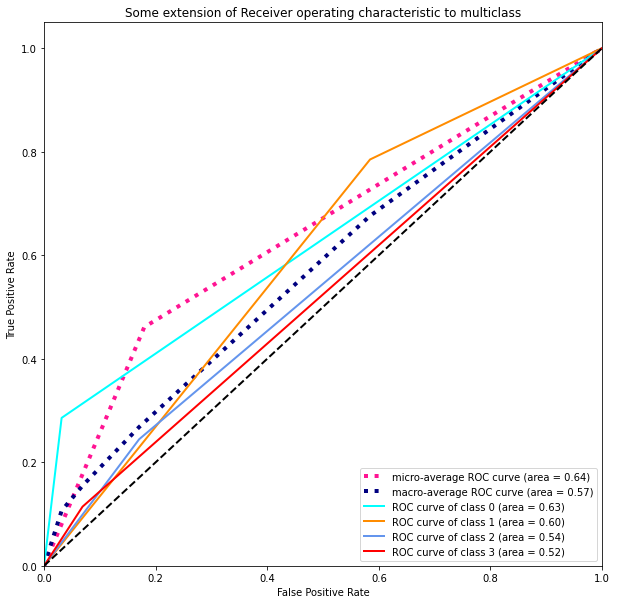

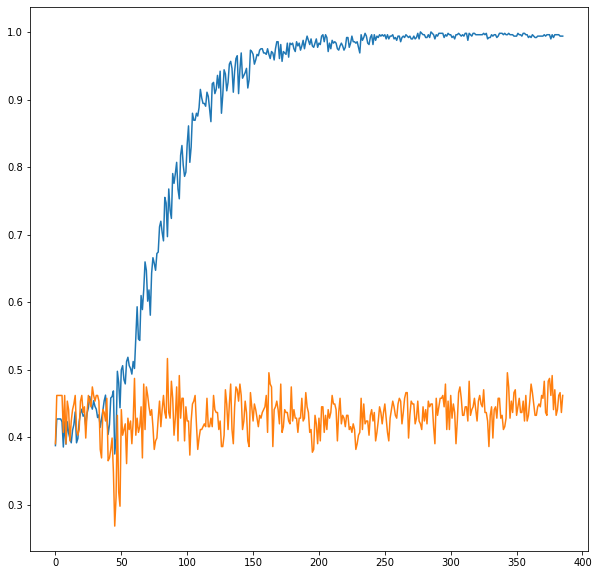

Fold: # 2

Early stopping occurred at epoch 367 with best_epoch = 67 and best_valid_accuracy = 0.4958
Best weights from best epoch are automatically used!


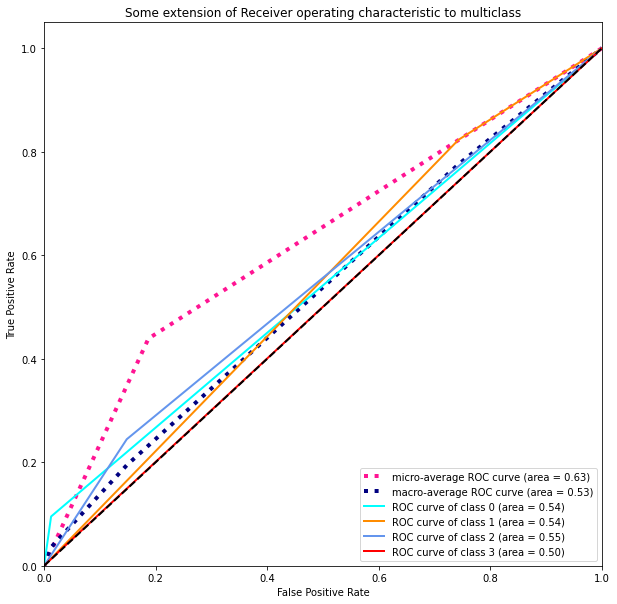

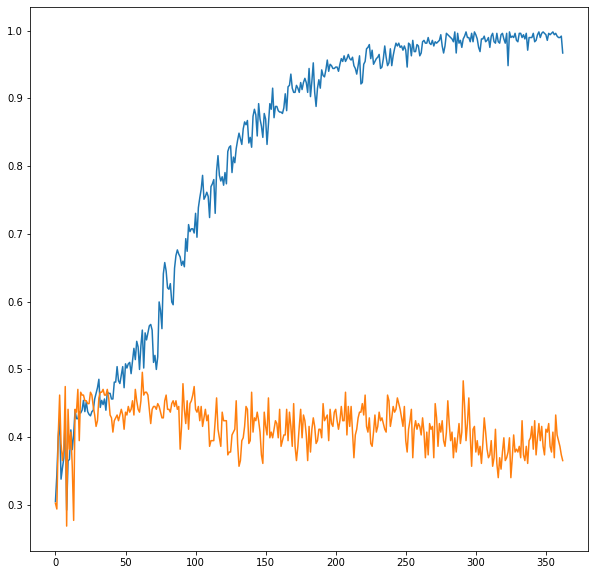

Fold: # 3

Early stopping occurred at epoch 409 with best_epoch = 109 and best_valid_accuracy = 0.52101
Best weights from best epoch are automatically used!


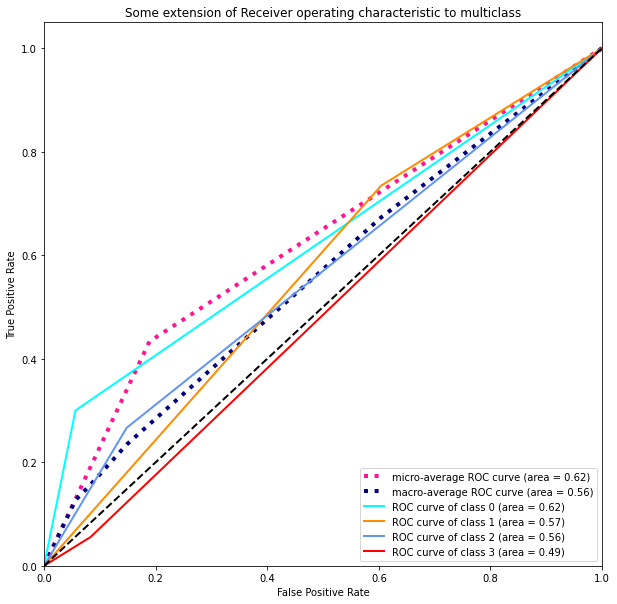

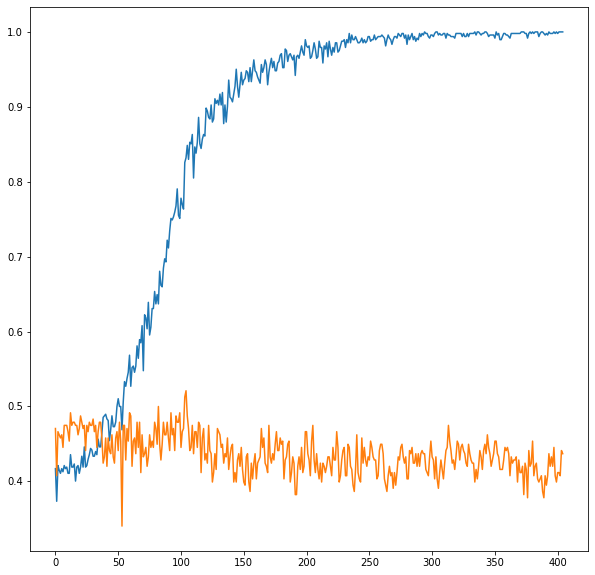

Fold: # 4

Early stopping occurred at epoch 382 with best_epoch = 82 and best_valid_accuracy = 0.48739
Best weights from best epoch are automatically used!


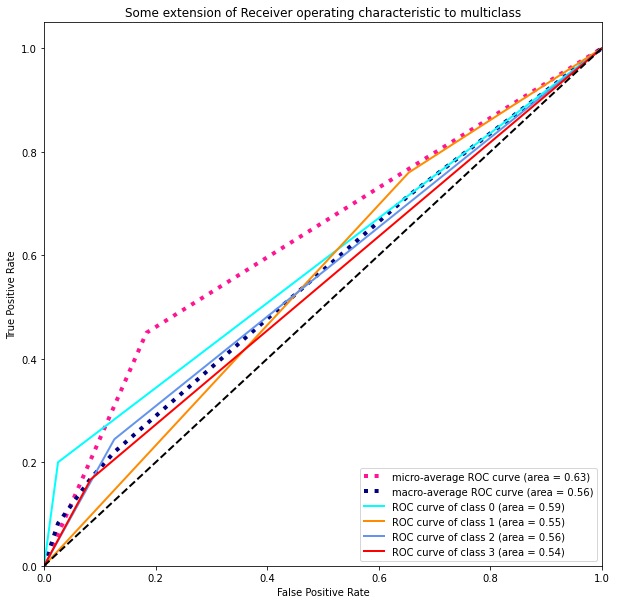

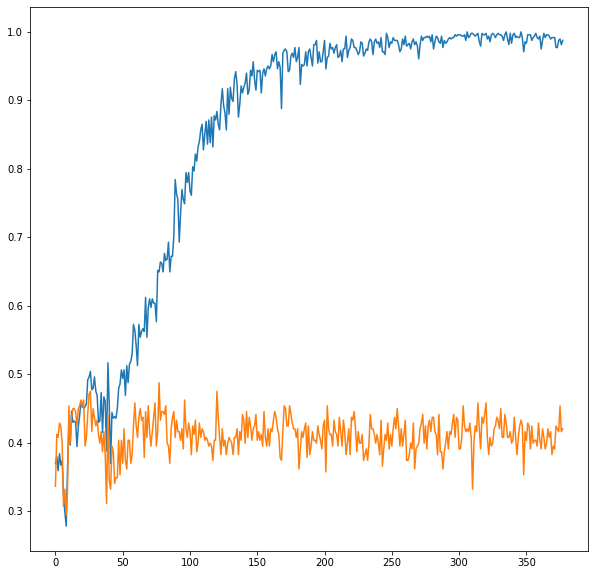

Fold: # 5

Early stopping occurred at epoch 345 with best_epoch = 45 and best_valid_accuracy = 0.46639
Best weights from best epoch are automatically used!


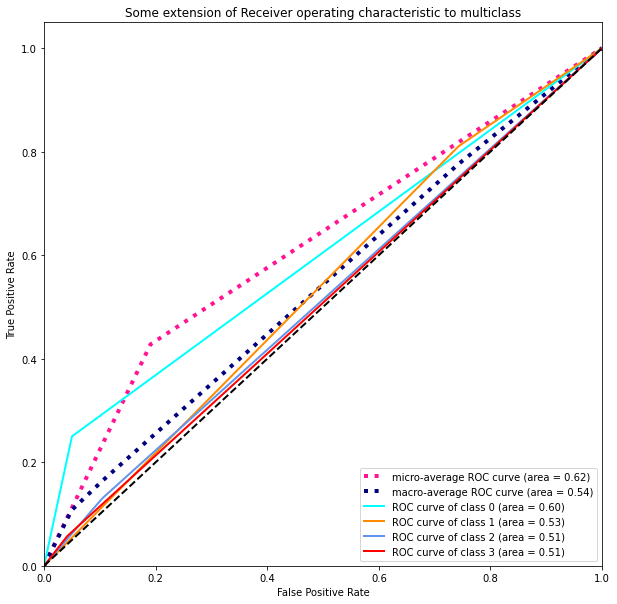

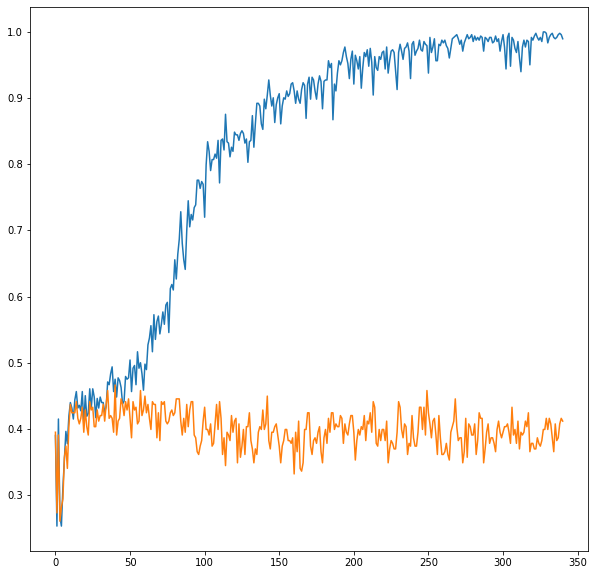

In [11]:
#Random Forest Classifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt
%matplotlib inline

X = np.array(dataset)

y = np.array(labels)
y = y.squeeze()


#originally from https://github.com/aryaprabawa/Startup-Invest-Prediction/blob/master/Predict_Investment_With_AUs.ipynb 
kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=420)

fold = 1
f1_scores = []
roc_auc_scores = []
accuracy_scores = []
for train, test in kf.split(X, y):
    print('Fold: #', fold)
    y_train = y[train]
    X_train = X[train]
    y_test = y[test]
    X_test = X[test]

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 1)

    clf = TabNetClassifier(
        n_d=64, n_a=64, n_steps=2,
        gamma=1.2, n_independent=2, n_shared=2,
        cat_emb_dim=1,
        lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params = {"gamma": 0.95,
                            "step_size": 10},
        scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
        seed = 1, verbose = 0
    )

    max_epochs = 1000

    h = clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=['train', 'valid'],
        max_epochs=max_epochs, patience=300,
        batch_size=64, virtual_batch_size=32
    )

    test_pred = clf.predict(X_test)
    #test_pred = test_pred.reshape(1,180)
    test_pred = label_binarize(test_pred, classes = [0,1,2,3])

    #y_test = y_test.reshape(1,180)
    y_test = label_binarize(y_test, classes=[0, 1, 2, 3])


    show_roc_plot(y_test, test_pred, fold)
    show_accuracy(clf.history['train_accuracy'], clf.history['valid_accuracy'])
    fold = fold + 1

In [146]:
np.random.seed(0)
import tensorflow as tf
import torch
from keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


poses = z
lengthp = len(poses)
middle = lengthp/2
p1 = poses[:int(middle)]
p2 = poses[int(middle):]
#y = labels.tolist()


#x = np.squeeze(z)
#x = x.reshape(x.shape[1:])

#explain what this does
tf.compat.v1.disable_eager_execution()

loss_function = BinaryCrossentropy()

tot1 = []
tot2 = []
for i in range(0,900):
        newdata1 = []
        for value in p1[i]:
            for coordinate in value:
                x = round(coordinate, 8)
                newdata1.append(x)
        newdata2 = []
        for value in p2[i]:
            for coordinate in value:
                x = round(coordinate, 8)
                newdata2.append(x)
        tot1.append(newdata1)
        tot2.append(newdata2)
        #for value in labels[i]:
        #        print(value)
final1 = np.array(tot1)
final2 = np.array(tot2)

dataset = np.hstack((final1, final2))
#dataset = dataset.reshape(1, 900 , 100)
labels = pd.DataFrame(labels)

#df = pd.DataFrame(dataset)
#labels = pd.DataFrame(y)
#mx = df.to_numpy().min()
#print(mx)

X = pd.DataFrame(dataset)
print(dataset.shape)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33)
X_train = np.array(X_train)
X_train = X_train.reshape(1,len(X_train),100)
print(X_train.shape)
X_test = np.array(X_test)
X_test = X_test.reshape(1,len(X_test),100)
print(X_test.shape)
y_train = np.array(y_train)
y_train = y_train.reshape(1,len(y_train))
print(y_train.shape)
y_test = np.array(y_test)
y_test = y_test.reshape(1,len(y_test))
print(y_test.shape)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#myModel = myModel.to(device)
# Check that it is on Cuda
#next(myModel.parameters()).device

additional_metrics = ['accuracy']
embedding_output_dims = 15
loss_function = CategoricalCrossentropy()
batch_size = 300
number_of_epochs = 10
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1     #progress bar

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Define the Keras model
model = Sequential()
model.add(LSTM(100, input_shape=(603, 100)))
model.add(Dense(603, activation = 'sigmoid'))
model.add(Dense(4, activation='sigmoid'))

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)


(900, 100)
(1, 603, 100)
(1, 297, 100)
(1, 603)
(1, 297)


In [1]:
# Train the model
#history = model.fit(X_train, y_train, epochs=number_of_epochs,batch_size=batch_size, verbose=verbosity_mode, validation_split=0.0)

# Give a summary
model.summary()

# Test the model after training
#test_results = model.evaluate(X_test, y_test, verbose=False)
#print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')


NameError: name 'model' is not defined

In [47]:
# FORMAT FOR LSTM INPUT
# [samples, time steps and features]
# [number of examples, 1 fps and 50 features per timestep (fps)]
np.random.seed(0)

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences


##                          ##
##        MODEL             ##
##                          ##


# Model configuration
additional_metrics = ['accuracy']
batch_size = 128
embedding_output_dims = 15
loss_function = BinaryCrossentropy()
max_sequence_length = 300
num_distinct_words = 5000
number_of_epochs = 5
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_distinct_words)
print(x_train.shape)
print(x_test.shape)

# Pad all sequences
padded_inputs = pad_sequences(x_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(x_test, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>

# Define the Keras model
model = Sequential()
model.add(Embedding(num_distinct_words, embedding_output_dims, input_length=max_sequence_length))
model.add(LSTM(10))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

# Give a summary
model.summary()

# Train the model
history = model.fit(padded_inputs, y_train, batch_size=batch_size, epochs=number_of_epochs, verbose=verbosity_mode, validation_split=validation_split)

# Test the model after training
test_results = model.evaluate(padded_inputs_test, y_test, verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')


(25000,)
(25000,)


KeyboardInterrupt: 

In [ ]:
###Importing libraries and setting seed
from download import download
import pandas as pd
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
import json
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

#matplotlib inline

###Set working directory
desktop = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')
os.chdir(desktop)

###Training the model for clf (Tabnet) object

#urltrain = "https://www.dropbox.com/s/9undp5mwff8bltn/train30k.csv?dl=0"
#train30kcsv = download(urltrain, "train30k.csv", replace=True)
#train = pd.read_csv("train30k.csv")

train = train.iloc[:,2:]

n_total_train = len(train)

train_indices, valid_indices = train_test_split(range(n_total_train), test_size=0.2, random_state=0)

clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.9, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

X_train = train.iloc[:,:-1].values[train_indices]
y_train = train.iloc[:,-1].values[train_indices]

X_valid = train.iloc[:,:-1].values[valid_indices]
y_valid = train.iloc[:,-1].values[valid_indices]

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

max_epochs = 1000 #Please only run if necessary, it might take on cuda 2-3 hours! -> It has built-in early-stopping so it won't run till the end probably.

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=64, virtual_batch_size=64
)

###Importing test data csv
urltest = "https://www.dropbox.com/s/vugb0d3t3ucpd4t/test_10k.csv?dl=0"
test10kcsv = download(urltest, "test10k.csv", replace=True)
test_df = pd.read_csv("test10k.csv")

###Preparing preprocessed data
test = test_df.iloc[:,2:]
X_test = test.iloc[:,:-1].values

X_test = sc.transform(X_test)

###Loading model and testing test accuracy
test_pred = clf.predict(X_test)

###Generating and saving json file from predicted values
y_pred_list = test_pred.tolist()

y_pred_pds = pd.Series(y_pred_list)
 
id_pds = test_df.iloc[:,1]

pred_dict = {}
for i in range(0,len(y_pred_list)):
    value = str(y_pred_pds[i])
    key = id_pds[i]
    pred_dict[key] = value
    
with open('test.json', 'w') as f:
  json.dump(pred_dict,f)
  
print("test.json is created successfully!")

In [12]:
import numpy as np
def evaluate(gold_path, pred_path):
    gold = json.load(open(gold_path))
    pred = json.load(open(pred_path))
    err = np.array([gold[key] != pred[key] for key in gold.keys()]).mean()
    return err


In [ ]:
#https://spyjetson.blogspot.com/2019/10/jetsonnano-human-pose-estimation-using.html

#SKELETON KEYPOINTS
{
//     {0,  "Nose"},
//     {1,  "Neck"},
//     {2,  "RShoulder"},
//     {3,  "RElbow"},
//     {4,  "RWrist"},
//     {5,  "LShoulder"},
//     {6,  "LElbow"},
//     {7,  "LWrist"},
//     {8,  "MidHip"},
//     {9,  "RHip"},
//     {10, "RKnee"},
//     {11, "RAnkle"},
//     {12, "LHip"},
//     {13, "LKnee"},
//     {14, "LAnkle"},
//     {15, "REye"},
//     {16, "LEye"},
//     {17, "REar"},
//     {18, "LEar"},
//     {19, "LBigToe"},
//     {20, "LSmallToe"},
//     {21, "LHeel"},
//     {22, "RBigToe"},
//     {23, "RSmallToe"},
//     {24, "RHeel"},
//     {25, "Background"}
// };

#HAND KEYPOINTS
#as seen on left hand when it is held open 
{
//     {0,  "BotR palm"},
//     {1,  "BotL palm"},
//     {2,  "Thumb Bot"},
//     {3,  "Thumb Mid"},
//     {4,  "Thumb Top"},
//     {5,  "Index Bot"},
//     {6,  "Index Mid1"},
//     {7,  "Index Mid2"},
//     {8,  "Index Top"},
//     {9,  "Middle Bot"},
//     {10, "Middle Mid1"},
//     {11, "Middle Mid2"},
//     {12, "Middle Top"},
//     {13, "Ring Bot"},
//     {14, "Ring Mid1"},
//     {15, "Ring Mid2"},
//     {16, "Ring Top"},
//     {17, "Pinky Bot"},
//     {18, "Pinky Mid1"},
//     {19, "Pinky Mid2"},
//     {20, "Pinky Top"},
// };




In [7]:
#Openpose Skeleton
#https://cmu-perceptual-computing-lab.github.io/openpose/web/html/doc/md_doc_02_output.html
#https://github.com/SonghaBan/DancingAI/blob/main/visframe.py 

l_pair_openpose25 = [
    [1, 2], [1, 5], [2, 3], [3, 4], [5, 6], [6, 7], [1, 8], 
    [8, 9], [9, 10], [10,11], [11,24], [11,22], [22,23],
    [8,12], [12, 13], [13,14], [14,21], [14,19], [19,20],
    [1, 0], 
    [0, 16], [18, 16], 
    [0, 15], [15, 17],
    ]

colors_openpose25 = np.array([
    [255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0],
    [85, 255, 0], [255,0,0], 
    [0, 255, 0], [0, 255, 85], [0, 255, 85], [0, 255, 85], [0, 255, 85], [0, 255, 85], 
    [0, 255, 170], [0, 255, 255],[0, 170, 255],[0, 170, 255],[0, 170, 255],[0, 170, 255],
    [0, 85, 255], 
#    [0, 0, 255], [85, 0, 255], 
#    [170, 0, 255],
    [255, 0, 255], [255, 0, 170], 
    [255, 0, 85], [255, 0, 0]])/255

print(len(l_pair_openpose25))
print(len(colors_openpose25))

24
24


In [ ]:
#Visualize Frame
#https://github.com/SonghaBan/DancingAI/blob/main/visframe.py 

#import torch
#import math
#import cv2
#import time
#from more_itertools.recipes import grouper, pairwise
#import moviepy.editor as mpy
#import more_itertools



def show_img(arr,idx=0):
    img = Image.fromarray(arr)
#    img.show()
    img.save('test1.jpg')

def visualize_frame(frame, joints=17, label=0):
    
    surface = gz.Surface(width=640, height=360, bg_color=(1,1,1))
    
    frame = open(frame)
    frame = json.load(frame)
    #frame.close()

    if joints == 25:
        frame = frame['people'][0]
        n_group = int(len(frame['pose_keypoints_2d']) / joints)
        pose = list(grouper(frame["pose_keypoints_2d"], n_group))
    else:
        n_group = int(len(frame['keypoints']) / joints)
        pose = list(grouper(frame["keypoints"], n_group))
    print(pose)
    
    if joints==25:
        l_pair = l_pair_openpose25
        line_color = colors_openpose25
    elif joints == 26:
        l_pair = l_pair_26
        line_color = line_color_26
        
    line_cnt = 0
    
    for limb in l_pair:
    #    print(limb)
        if limb[0] == joints and (joints == 17 or joints == 26):
            x1, y1, _ = (np.array(pose[5]) + np.array(pose[6])) / 2 #neck
        else:
            x1, y1, _ = pose[limb[0]]
        x2, y2, _ = pose[limb[1]]
        line = gz.polyline(points=[(x1,y1), (x2,y2)], stroke_width = 6, stroke=line_color[line_cnt])
    #    print('line', line_cnt)
        line_cnt += 1
        line.draw(surface)
    
    for idx in range(len(pose)):
    #    print(idx)
        x1, y1,_ = pose[idx]
        joint = gz.circle(4, xy=[x1,y1], fill=(0,0,0))
        joint.draw(surface)

    show_img(surface.get_npimage(), label)



In [ ]:
visualize_frame('D:\Videos thesis\SuJu16_poses\SuJu16_poses\\frame7_keypoints.json', joints = 25)

In [ ]:
#POST PROCESSING

#check if difference between frames is too large


#https://github.com/SonghaBan/DancingAI


#def check_previous_frame(filename)

#compute difference with one frame before here


In [ ]:
#https://sduxbury.medium.com/how-you-can-build-practical-applications-by-quantifying-observations-from-video-e266b945eea0
#Point sets are in the form [coordinate, coordinate, confidence]